In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn/train_v2/train_v2.csv
/kaggle/input/customer-churn/user_logs_v2/user_logs_v2.csv
/kaggle/input/customer-churn/members_v3/members_v3.csv
/kaggle/input/customer-churn/transactions_v2/transactions_v2.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os
import scipy
from scipy.stats.mstats import mode
import pickle
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
import gc

In [3]:
members1 = pd.read_csv('/kaggle/input/customer-churn/members_v3/members_v3.csv')  # unique customers on msno, no duplicates here
train_v21 = pd.read_csv('/kaggle/input/customer-churn/train_v2/train_v2.csv')  # Again unique on msno, no duplicated here
transactions1 = pd.read_csv('/kaggle/input/customer-churn/transactions_v2/transactions_v2.csv') # No unique id, even msno is duplicate 
user_logs1 = pd.read_csv('/kaggle/input/customer-churn/user_logs_v2/user_logs_v2.csv') # No unique id, even msno is duplicate

In [4]:
# consider only 50% of the sample from each datasets given ram capacity 16GB
members = members1.sample(frac = 0.5)
train_v2 = train_v21.sample(frac = 0.5)
transactions = transactions1.sample(frac = 0.5)
user_logs = user_logs1.sample(frac = 0.5)

In [5]:
del members1, train_v21, transactions1, user_logs1

In [6]:
# get the list of common msno across all tables
s1 = (set(train_v2.msno) & set(members.msno) & set(transactions.msno) & set(user_logs.msno))
l1 = list(s1)
print('count of common msno :', len(l1))

# create a dataframe and left join with train_v2 (having unique msno and target)
com_data = pd.DataFrame(l1, columns = ['msno'])
master_data = com_data.merge(train_v2, on = 'msno', how = 'left')
print('common msno :', master_data.shape)


count of common msno : 94713
common msno : (94713, 2)


In [7]:
train_mem = pd.merge(master_data, transactions, on = 'msno', how = 'left')
train_mem_txn = pd.merge(train_mem, members, on = 'msno', how = 'left')
train_mem_txn_user_log1 = pd.merge(train_mem_txn, user_logs, on = 'msno', how = 'left')
train_mem_txn_user_log1.shape

(1018202, 23)

In [8]:
t1 = pd.DataFrame(train_mem_txn_user_log1.msno.value_counts(dropna=False), columns=['msno'])
t1.reindex()
t1.head()

,msno
aP/PsAIVAhPLMwkMwxNsi1bJFMg1vdGWFNc/z8Tkomw=,361
CP+iV346CbsrCdG1BWt2r0t0jJpS5Ns9AhPukIoNWTc=,361
GUlOynwcbchLoK1DjZ9pMqC3HiK1BOGDV3g4xuUeNA0=,360
o5aFK3grQrjlHACDVvS0cPa1KvLq9x9KeTM/L2SgLz0=,324
Y0a/7FB6Irar2JM3i8qQPmgCYonQrLglc0W//BlQgGM=,324


In [9]:
num = ['bd', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'actual_amount_paid']
cat = ['city', 'gender', 'registered_via', 'payment_method_id', 'payment_plan_days', 'plan_list_price', 'is_auto_renew', 'is_cancel']
date1 = ['registration_init_time', 'transaction_date', 'membership_expire_date', 'date']

# drop all date variables for now
train_mem_txn_user_log1.drop(date1, axis=1, inplace=True)

# replace numeric NaN with median values of num columns
for var in num:
    train_mem_txn_user_log1.loc[:, var].fillna(train_mem_txn_user_log1.loc[:, var].median(), inplace = True)

In [10]:
from sklearn import preprocessing
import pickle

# Impute missing before label encoding
from sklearn.base import TransformerMixin
class cat_imputer(TransformerMixin):
    def _init_(self):
        ''' categrical Imputer'''
    def fit(self, x, y=None):
        self.fill = x.value_counts().index[0]
    def transform(self, x, y = None):
        return x.fillna(self.fill)
    
for i in cat:
    s = cat_imputer()
    s.fit(train_mem_txn_user_log1[i])
    train_mem_txn_user_log1[i] = s.transform(train_mem_txn_user_log1[i])
    
for i in cat:
    train_mem_txn_user_log1[i] = train_mem_txn_user_log1[i].astype(str)
train_mem_txn_user_log1[cat].head()

,city,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,is_cancel
0,1,male,7,41,30,100,1,0
1,1,male,7,41,30,100,1,0
2,1,male,7,41,30,99,1,0
3,1,male,7,41,30,99,1,0
4,1,male,7,41,30,99,1,0


In [11]:
cat1 = []
num1 = []
other = []

for val in train_mem_txn_user_log1.columns.tolist():
    if train_mem_txn_user_log1[val].dtypes == 'int64':
        num1.append(val)
    elif train_mem_txn_user_log1[val].dtypes == 'float64':
        num1.append(val)
    elif train_mem_txn_user_log1[val].dtypes == 'O':
        cat1.append(val)
    else:
        other.append(val)
        
cat1.remove('msno'); num1.remove('is_churn')       

In [12]:
train_mem_txn_user_log2 = train_mem_txn_user_log1.copy()

In [13]:
aggregate = {
    'actual_amount_paid':['median'],
    'bd': ['median'],
    'num_25': ['median'],
    'num_50': ['median'],
    'num_75': ['median'],
    'num_985': ['median'],
    'num_100': ['median'],
    'num_unq': ['median'],
    'total_secs': ['median']
}

train_mem_txn_user_log1_num = train_mem_txn_user_log2[num1+['msno']].groupby(['msno'], as_index=False, sort=False).agg(aggregate)
train_mem_txn_user_log1_num.columns = [''.join(col).strip() for col in train_mem_txn_user_log1_num.columns.values]

In [14]:
from pandasql import sqldf
pysqldf =  lambda q: sqldf(q, globals())

q = """
select
    msno,
    count(*) as payment_method_id,
    count(*) as payment_plan_days,
    count(*) as plan_list_price,
    count(*) as is_auto_renew,
    count(*) as is_cancel,
    count(*) as city,
    count(*) as gender,
    count(*) as registered_via
    
from train_mem_txn_user_log2
group by msno
"""
train_mem_txn_user_log1_char1 = pysqldf(q)
train_mem_txn_user_log1_char1.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,is_auto_renew,is_cancel,city,gender,registered_via
0,++1GCIyXZO7834NjDKmcK1lBVLQi9PsN6sOC7wfW+8g=,3,3,3,3,3,3,3,3
1,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,20,20,20,20,20,20,20,20
2,++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=,9,9,9,9,9,9,9,9
3,++JHjhFuSV7upQUju29UmOHStYHmNiW5th0xEyUGW8s=,1,1,1,1,1,1,1,1
4,++M4G6SSlhINyHbCMt5KVjPdbDAZkaJ0a51FF8lGr04=,11,11,11,11,11,11,11,11


In [15]:
gender = {'male':1, 'female': 2}
train_mem_txn_user_log2.gender = [gender[x] for x in train_mem_txn_user_log2.gender]
for i in cat1:
    train_mem_txn_user_log2[i] = train_mem_txn_user_log2[i].astype(np.int)

In [16]:
train_mem_txn_user_log1_0 = pd.merge(train_mem_txn_user_log1_num, train_mem_txn_user_log1_char1, on = 'msno', how='left')
train_mem_txn_user_log1 = pd.merge(master_data, train_mem_txn_user_log1_0, on = 'msno', how='left')

In [17]:
# do the modeling work from here
from sklearn.model_selection import train_test_split
target = 'is_churn'

Intime_x = train_mem_txn_user_log1.drop(['msno', 'is_churn'], axis = 1)
Intime_y = train_mem_txn_user_log1.loc[:, train_mem_txn_user_log1.columns == target]

xTrain, xTest, yTrain, yTest = train_test_split(Intime_x, Intime_y, test_size = 0.5, random_state = 0)

In [18]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

In [19]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 30, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 6, num = 5)]
min_samples_split = [int(x) for x in np.linspace(2, 12, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 10)]
max_leaf_nodes = [None, 2, 3, 4, 5]
bootstrap = [True, False]

random_grid_rfc = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'criterion': criterion,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'max_leaf_nodes': max_leaf_nodes,
                   'bootstrap': bootstrap}

In [20]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc_random = RandomizedSearchCV(estimator = RFC(random_state =0), param_distributions = random_grid_rfc, n_iter = sum(map(len, random_grid_rfc.values()))-5, cv = 2, verbose = 5, random_state =0, n_jobs = -1, scoring = 'roc_auc')
rfc_random.fit(xTrain, yTrain)

Fitting 2 folds for each of 42 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   11.5s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [21]:
rfc_tunned = rfc_random.best_estimator_.fit(xTrain, yTrain)
xTrain_score = rfc_tunned.predict_proba(xTrain)[:,1].astype('float64')
xTest_score = rfc_tunned.predict_proba(xTest)[:,1].astype('float64')
auc_xTrain = roc_auc_score(yTrain, xTrain_score)
auc_xTest = roc_auc_score(yTest, xTest_score)
dataset = pd.DataFrame(['Train', 'Test'], columns = ['dataset'])
auc = pd.DataFrame([auc_xTrain, auc_xTest], columns = ['aucroc']) 
table = pd.concat([dataset, auc], axis = 1)
table

,dataset,aucroc
0,Train,0.764871
1,Test,0.768840


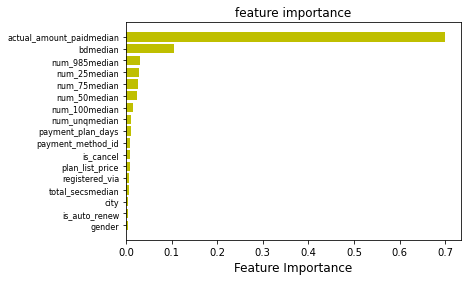

In [22]:
# get the important variables since other models are throwing error cause of excessive memory use at the time of hyperparameter tunning
feature_importances = pd.DataFrame(rfc_tunned.feature_importances_,
                                   index = xTrain.columns,
                                   columns = ['importance']).sort_values('importance', ascending = False)
feature_importances = feature_importances.loc[feature_importances['importance'] > 0.001, :]
features = xTrain.loc[:, feature_importances.index.tolist()].columns.tolist()
importances = rfc_tunned.feature_importances_
importances = np.array(list(filter(lambda x: x>0.001, importances)))
indices = np.argsort(importances)
plt.title('feature importance')
plt.barh(range(len(indices)), importances[indices], color = 'y', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=8)
plt.xlabel('Feature Importance', fontsize=12)
plt.savefig('featuretools_feature_importances.png')

In [23]:
rfc_random = RandomizedSearchCV(estimator = RFC(random_state =0), param_distributions = random_grid_rfc, n_iter = sum(map(len, random_grid_rfc.values()))-5, cv = 2, verbose = 5, random_state =0, n_jobs = -1, scoring = 'roc_auc')
rfc_random.fit(xTrain.loc[:, feature_importances.index.tolist()], yTrain)

Fitting 2 folds for each of 42 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   10.1s finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [24]:
rfc_tunned = rfc_random.best_estimator_.fit(xTrain.loc[:, feature_importances.index.tolist()], yTrain)
xTrain_score = rfc_tunned.predict_proba(xTrain.loc[:, feature_importances.index.tolist()])[:,1].astype('float64')
xTest_score = rfc_tunned.predict_proba(xTest.loc[:, feature_importances.index.tolist()])[:,1].astype('float64')
auc_xTrain = roc_auc_score(yTrain, xTrain_score)
auc_xTest = roc_auc_score(yTest, xTest_score)
dataset = pd.DataFrame(['Train', 'Test'], columns = ['dataset'])
auc = pd.DataFrame([auc_xTrain, auc_xTest], columns = ['aucroc']) 
table = pd.concat([dataset, auc], axis = 1)
table

,dataset,aucroc
0,Train,0.776652
1,Test,0.776204


In [25]:
pd.DataFrame().to_excel('benchmark_model.xlsx')
from openpyxl import load_workbook
book = load_workbook('benchmark_model.xlsx')
writer = pd.ExcelWriter('benchmark_model.xlsx', engine = 'openpyxl')
writer.book = book
table.to_excel(writer, sheet_name = 'RFC', index = False, startrow=2)
std = book.get_sheet_by_name('Sheet1')
book.remove_sheet(std)
writer.save()

In [26]:
feature_importances.to_excel(writer, sheet_name = 'feature_importances', startrow=2)
writer.save()

In [27]:
def model_performance(yTrain, xTrain_score, model_name, xTrain, yTest, xTest_score, xTest, combined_data, writer, sheet_name):
    # calculate roc curves on Train data only
    ns_probs = [0 for _ in range(len(yTrain))]
    ns_auc = roc_auc_score(yTrain, ns_probs)
    lr_auc = roc_auc_score(yTrain, xTrain_score)
    # summarize scores
    print('Train : No Model Score: ROC AUC=%.3f' % (ns_auc))
    print('Train : Model : ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(yTrain, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(yTrain, xTrain_score)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label= 'Train:No Model Score')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label= 'Train:Model')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    # Precision and recall and F1-score on Train data only
    yhat = model_name.predict(xTrain.loc[:, feature_importances.index.tolist()])
    precision, recall, _ = roc_curve(yTrain, xTrain_score)
    f1 = f1_score(yTrain['is_churn'], yhat) 
    auc = metrics.auc(precision, recall)
    # summarize scores on Train data only
    print('Train : f1=%.3f auc=%.3f' % (f1, auc))
    pd.DataFrame([f1, auc], index=['f1','AUC'], columns = ['Train']).to_excel(writer, sheet_name = sheet_name, startrow=6)
    writer.save()
    
    # calculate roc curves on Test data only
    ns_probs = [0 for _ in range(len(yTest))]
    ns_auc = roc_auc_score(yTest, ns_probs)
    lr_auc = roc_auc_score(yTest, xTest_score)
    # summarize scores
    print('Test : No Model Score: ROC AUC=%.3f' % (ns_auc))
    print('Test : Model : ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(yTest, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(yTest, xTest_score)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label= 'Test:No Model Score')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label= 'Test:Model')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    # Precision and recall and F1-score on Test data only
    yhat = model_name.predict(xTest.loc[:, feature_importances.index.tolist()])
    precision, recall, _ = roc_curve(yTest, xTest_score)
    f1 = f1_score(yTest['is_churn'], yhat) 
    auc = metrics.auc(precision, recall)
    # summarize scores
    print('Test : Model : f1=%.3f auc=%.3f' % (f1, auc))
    pd.DataFrame([f1, auc], index=['f1','AUC'], columns = ['Test']).to_excel(writer, sheet_name = sheet_name, startrow=10)
    writer.save()

    total_score1 = model_name.predict_proba(combined_data.loc[:, feature_importances.index.tolist()])[:,1].astype('float64')
    total_score = pd.DataFrame(total_score1, columns = ['pred'], index=combined_data.index.tolist()).apply(lambda x: round(x)).astype('int64')
    
    # calculate roc curves on Total(Train_Test) data 
    ns_probs = [0 for _ in range(len(combined_data.loc[:, target]))]
    ns_auc = roc_auc_score(combined_data.loc[:, target], ns_probs)
    lr_auc = roc_auc_score(combined_data.loc[:, target], total_score1)
    # summarize scores
    print('Total : No Model Score: ROC AUC=%.3f' % (ns_auc))
    print('Total : Model : ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(combined_data.loc[:, target], ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(combined_data.loc[:, target], total_score1)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Total:No Model Score')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Total:Model')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    # Precision and recall and F1-score on Train data only
    yhat = model_name.predict(combined_data.loc[:, feature_importances.index.tolist()])
    precision, recall, _ = roc_curve(combined_data.loc[:, target], total_score1)
    f1 = f1_score(combined_data['is_churn'], yhat) 
    auc = metrics.auc(precision, recall)
    
    weighted_accuracy = recall_score(combined_data['is_churn'], total_score['pred'], average='weighted')
    # summarize scores on Total(Train_Test) data
    print('Unique_Customers : Model : f1=%.3f auc=%.3f weighted_accuracy=%.3f' % (f1, auc, weighted_accuracy))
    
    pd.DataFrame([f1, auc, weighted_accuracy], index=['f1','AUC', 'weighted_accuracy'], columns = ['Total_uniq_at_custlevel']).to_excel(writer, sheet_name = sheet_name, startrow=14)
    writer.save()
    writer.close()
    

Train : No Model Score: ROC AUC=0.500
Train : Model : ROC AUC=0.777


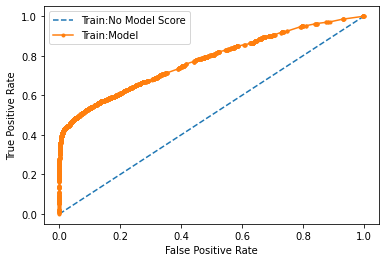

Train : f1=0.478 auc=0.777
Test : No Model Score: ROC AUC=0.500
Test : Model : ROC AUC=0.776


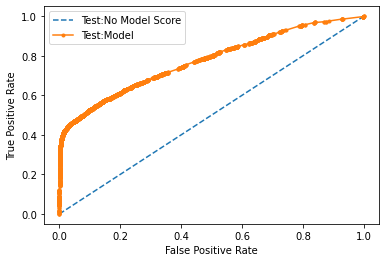

Test : Model : f1=0.479 auc=0.776
Total : No Model Score: ROC AUC=0.500
Total : Model : ROC AUC=0.776


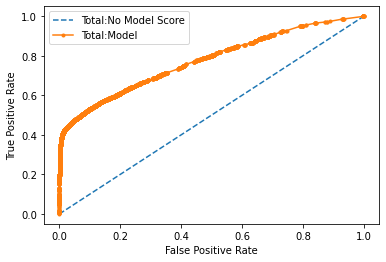

Unique_Customers : Model : f1=0.479 auc=0.776 weighted_accuracy=0.950


In [28]:
model_performance(yTrain, xTrain_score, rfc_tunned, xTrain, yTest, xTest_score, xTest, train_mem_txn_user_log1, writer, 'RFC')

In [29]:
######################################### Gradient Boosting Hyperparameter Model ####################################
from sklearn.ensemble import GradientBoostingClassifier
random_grid_gbc = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [x for x in np.linspace(start = 0.01, stop = 1, num = 10)],
                   'criterion': ['friedman_mse', 'mse'],
                   'max_features': max_features,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'max_depth': max_depth}

In [30]:
gbc_random = RandomizedSearchCV(estimator = GradientBoostingClassifier(random_state =0), param_distributions = random_grid_gbc, n_iter = sum(map(len, random_grid_gbc.values()))-5, cv = 2, verbose = 2, random_state =0, n_jobs = -1, scoring = 'roc_auc')
gbc_random.fit(xTrain.loc[:, feature_importances.index.tolist()], yTrain)
print(gbc_random.best_params_)

Fitting 2 folds for each of 37 candidates, totalling 74 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  1.6min finished


{'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 6, 'loss': 'exponential', 'learning_rate': 0.01, 'criterion': 'friedman_mse'}


In [31]:
gbc_tunned = gbc_random.best_estimator_.fit(xTrain.loc[:, feature_importances.index.tolist()], yTrain)
xTrain_score = gbc_tunned.predict_proba(xTrain.loc[:, feature_importances.index.tolist()])[:,1].astype('float64')
xTest_score = gbc_tunned.predict_proba(xTest.loc[:, feature_importances.index.tolist()])[:,1].astype('float64')
auc_xTrain = roc_auc_score(yTrain, xTrain_score)
auc_xTest = roc_auc_score(yTest, xTest_score)
dataset = pd.DataFrame(['Train', 'Test'], columns = ['dataset'])
auc = pd.DataFrame([auc_xTrain, auc_xTest], columns = ['aucroc']) 
table = pd.concat([dataset, auc], axis = 1)
table

,dataset,aucroc
0,Train,0.790524
1,Test,0.787799


In [32]:
book = load_workbook('benchmark_model.xlsx')
writer = pd.ExcelWriter('benchmark_model.xlsx', engine = 'openpyxl')
writer.book = book
table.to_excel(writer, sheet_name = 'GBC', index = False, startrow=2)
writer.save()

Train : No Model Score: ROC AUC=0.500
Train : Model : ROC AUC=0.791


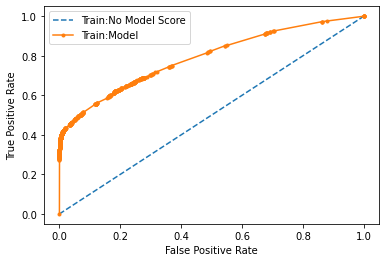

Train : f1=0.000 auc=0.791
Test : No Model Score: ROC AUC=0.500
Test : Model : ROC AUC=0.788


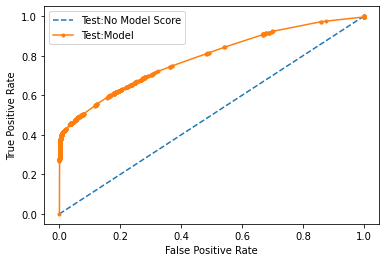

Test : Model : f1=0.000 auc=0.788
Total : No Model Score: ROC AUC=0.500
Total : Model : ROC AUC=0.789


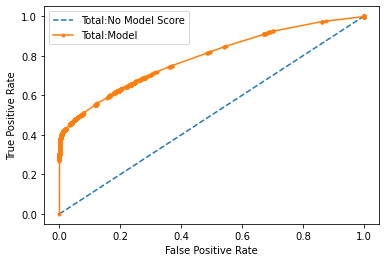

Unique_Customers : Model : f1=0.000 auc=0.789 weighted_accuracy=0.927


In [33]:
model_performance(yTrain, xTrain_score, gbc_tunned, xTrain, yTest, xTest_score, xTest, train_mem_txn_user_log1, writer, 'GBC')

In [34]:
##################################### XGBClassifier #############################################
import xgboost

from xgboost import XGBClassifier

random_grid_xgb = {'booster': ['gbtree', 'gblinear'],
                   'n_estimators': n_estimators,
                   'learning_rate': [x for x in np.linspace(start = 0.01, stop = 1, num = 10)],
                   'gamma': [2, 5, 10],
                   'max_depth': max_depth}

In [35]:
xgb_random = RandomizedSearchCV(estimator = XGBClassifier(random_state =0), param_distributions = random_grid_xgb, n_iter = sum(map(len, random_grid_xgb.values()))-5, cv = 2, verbose = 2, random_state =0, n_jobs = -1, scoring = 'roc_auc')
xgb_random.fit(xTrain.loc[:, feature_importances.index.tolist()], yTrain)
print(xgb_random.best_params_)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.3s finished


{'n_estimators': 16, 'max_depth': 3, 'learning_rate': 0.56, 'gamma': 5, 'booster': 'gbtree'}


In [36]:
xgb_tunned = xgb_random.best_estimator_.fit(xTrain.loc[:, feature_importances.index.tolist()], yTrain)
xTrain_score = xgb_tunned.predict_proba(xTrain.loc[:, feature_importances.index.tolist()])[:,1].astype('float64')
xTest_score = xgb_tunned.predict_proba(xTest.loc[:, feature_importances.index.tolist()])[:,1].astype('float64')
auc_xTrain = roc_auc_score(yTrain, xTrain_score)
auc_xTest = roc_auc_score(yTest, xTest_score)
dataset = pd.DataFrame(['Train', 'Test'], columns = ['dataset'])
auc = pd.DataFrame([auc_xTrain, auc_xTest], columns = ['aucroc']) 
table = pd.concat([dataset, auc], axis = 1)
table

,dataset,aucroc
0,Train,0.801192
1,Test,0.792351


In [37]:
book = load_workbook('benchmark_model.xlsx')
writer = pd.ExcelWriter('benchmark_model.xlsx', engine = 'openpyxl')
writer.book = book
table.to_excel(writer, sheet_name = 'XGB', index = False, startrow=2)
writer.save()

Train : No Model Score: ROC AUC=0.500
Train : Model : ROC AUC=0.801


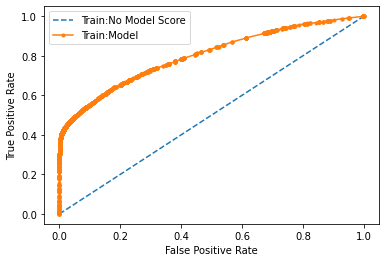

Train : f1=0.519 auc=0.801
Test : No Model Score: ROC AUC=0.500
Test : Model : ROC AUC=0.792


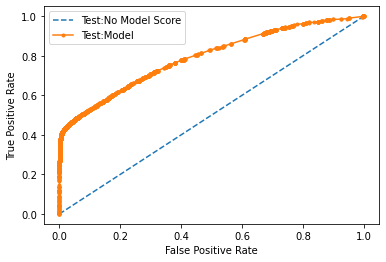

Test : Model : f1=0.523 auc=0.792
Total : No Model Score: ROC AUC=0.500
Total : Model : ROC AUC=0.797


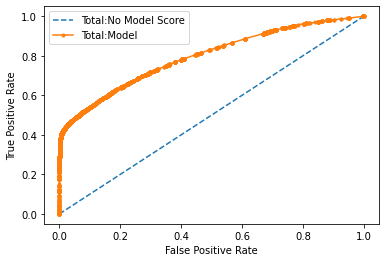

Unique_Customers : Model : f1=0.521 auc=0.797 weighted_accuracy=0.952


In [38]:
model_performance(yTrain, xTrain_score, xgb_tunned, xTrain, yTest, xTest_score, xTest, train_mem_txn_user_log1, writer, 'XGB')